### advect_diffuse_2d

Create a 2d PINN that interpolate c and reconstruct $\mathbf{v}$ and D

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

#Set default dtype to float32(the same as MRI data)
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(4399)

# Random number generators in other libraries
np.random.seed(4399)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


# *Data Prep*

Training and Testing data is prepared from the solution file

In [3]:
# create some test 3D volume sequence following advect-diffuse equation
#  ∂u/∂t + v·∇u = D∇²u

nx, ny = 50, 50 # grid points
Lx, Ly = 1.0, 1.0 # domain size

dx, dy = Lx/nx, Ly/ny

dt = 0.001 # time step
nt = 500 # number of total time steps

jump_t = 50 # save data every jump_t time steps (sparse training data)

u, v = 0.4, 0.7 # constant velocity toward (1,1)
D = 0.01 # diffusion coefficient

# create grid
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Initial condition: gaussian blob at (0.25, 0.25)
deviation = 0.05
centers = [(0.25, 0.25), (0.5, 0.5), (0.3, 0.4), (0.4, 0.3)]
noise_std = 0.01
# Hearder case Initial condition: multiple gaussian blobs at specified centers with sharper edges and small noise

rho = np.zeros_like(X)
for cx, cy in centers:
    rho += 1 / (deviation / 2) * np.sqrt(2 * np.pi) * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * (deviation / 2)**2))

# add small noise
rho += np.random.normal(0, noise_std, rho.shape)
rho = np.maximum(rho, 0)  # ensure non-negative

# get the laplacian field, using periodic boundaries(leftest is rightest)
def laplacian(f, dx, dy):
    return (
        (np.roll(f, 1, axis=0) - 2*f + np.roll(f, -1, axis=0)) / dx**2 +
        (np.roll(f, 1, axis=1) - 2*f + np.roll(f, -1, axis=1)) / dy**2
    )


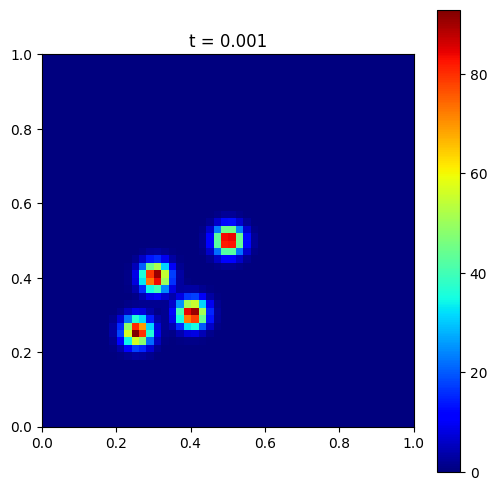

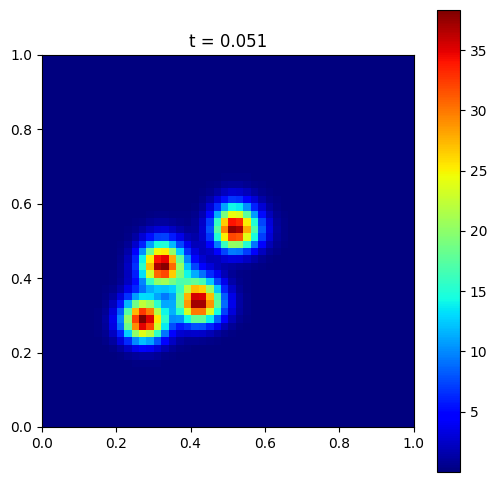

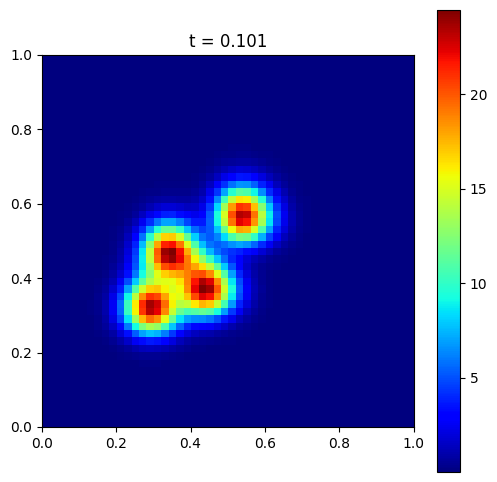

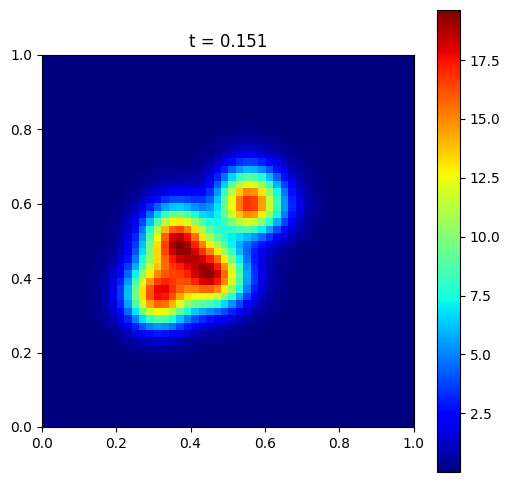

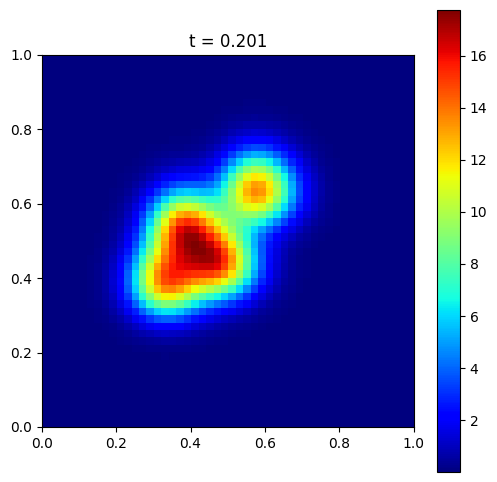

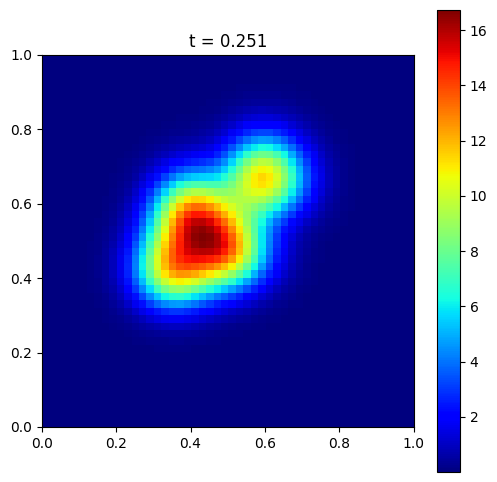

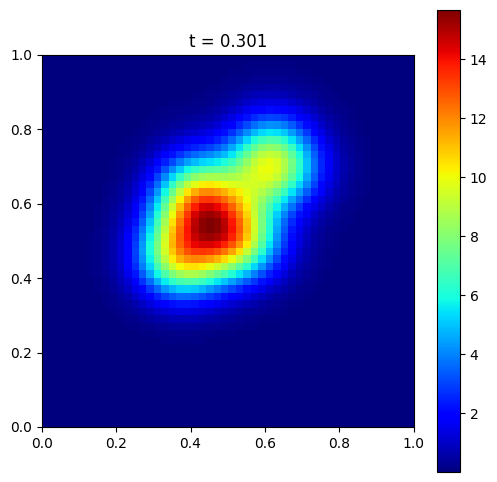

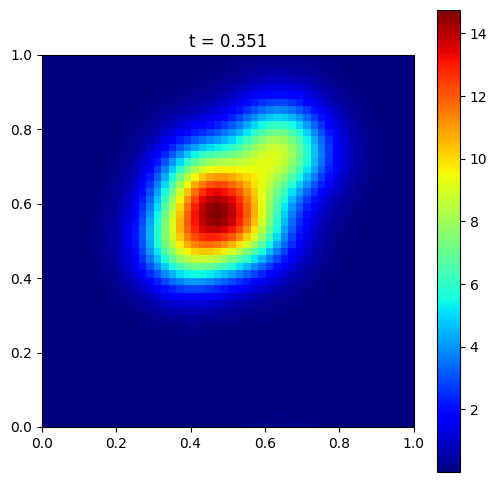

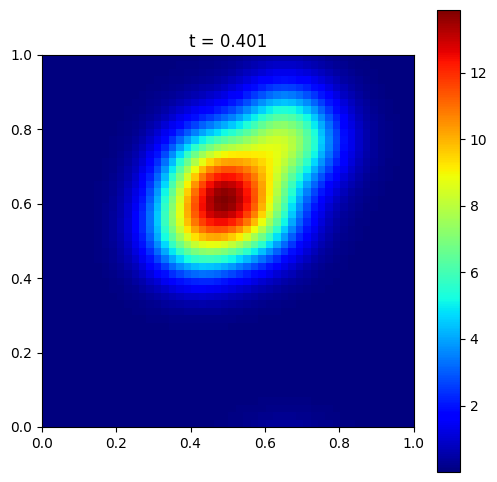

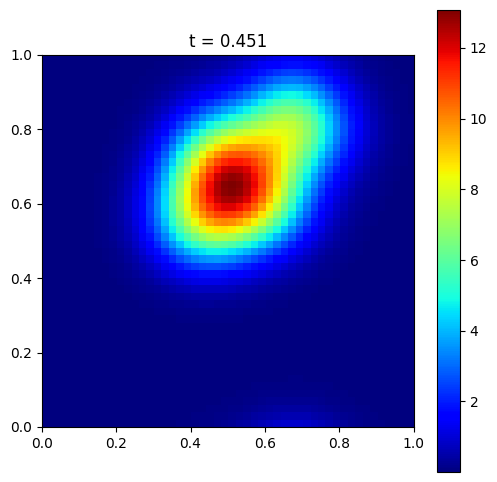

(50, 50, 10)
(50, 50, 10)


In [4]:
# Time stepping
train_rho_list = []
test_rho_list = []
for n in range(nt):
    # RK1 semi-lagrange and directly select the upwind point
    advect = -u * (np.roll(rho, -1, axis=0) - np.roll(rho, 1, axis=0)) / (2*dx) \
             -v * (np.roll(rho, -1, axis=1) - np.roll(rho, 1, axis=1)) / (2*dy)
    diffuse = D * laplacian(rho, dx, dy)
    rho += dt * (advect + diffuse)
    if n % (jump_t/2) == 0:
        # interleave train and test data
        if n % jump_t != 0:
            test_rho_list.append(rho.copy())
        else:
            plt.figure(figsize=(6, 6))
            plt.imshow(rho.T, cmap='jet', origin='lower', extent=(0, Lx, 0, Ly))
            plt.colorbar()
            plt.title(f"t = {dt*(n+1):.3f}")
            plt.show()
            train_rho_list.append(rho.copy())

# save rho_list into npy file
train_rho_array = np.stack(train_rho_list, axis=-1) # shape (nx, ny, nt/50)
print(train_rho_array.shape)
test_rho_array = np.stack(test_rho_list, axis=-1) # shape (nx, ny, nt/50)
print(test_rho_array.shape)

In [5]:
# generate training data, with shape (N,3) for X_train and (N,1) for y_train

x_in = np.linspace(0, Lx, nx)
y_in = np.linspace(0, Ly, ny)
n_train = train_rho_array.shape[-1]
t_in = dt * (np.arange(n_train) * jump_t + 1) # align with train_rho_array time steps
X_in, Y_in, T_in = np.meshgrid(x_in, y_in, t_in)
print(X_in.shape, Y_in.shape, T_in.shape)
# flat from (nx, ny, nt/50) to (nx*ny*nt/50, 1), and pack
X_train = np.stack([X_in.ravel(), Y_in.ravel(), T_in.ravel()], axis=1).astype(np.float32)
y_train = train_rho_array.reshape(-1, 1).astype(np.float32) # shape (nx*ny*nt/50, 1)
print(X_train.shape, y_train.shape)

# convert to torch tensor
X_train = torch.from_numpy(X_train).to(device)
y_train = torch.from_numpy(y_train).to(device)

(50, 50, 10) (50, 50, 10) (50, 50, 10)
(25000, 3) (25000, 1)


# Physics Informed Neural Network

In [6]:
import torch.nn as nn

loss_pde_list = []
loss_data_list = []

# 1. Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # only a four layer fully connected network with tanh activation
        self.net = nn.Sequential(
            nn.Linear(3, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
        
        # --- Make D and v learnable parameters! ---
        # Initialize them with wrong values to see if the network can find the true ones.
        self.D = nn.Parameter(torch.tensor([0.001])) 
        # self.vx = nn.Parameter(torch.tensor([0.0]))
        # self.vy = nn.Parameter(torch.tensor([0.0]))
        # Make vx and vy scalar fields or another sub PINN (functions of x, y)
        self.vx_net = nn.Sequential(
            nn.Linear(2, 10), nn.Tanh(),
            nn.Linear(10, 1)
        )
        self.vy_net = nn.Sequential(
            nn.Linear(2, 10), nn.Tanh(),
            nn.Linear(10, 1)
        )


    def forward(self, x_in, y_in, t_in):
        # Concatenate inputs
        input_tensor = torch.cat([x_in, y_in, t_in], dim=1)
        return self.net(input_tensor)

    # 2. Define the Loss Function (Data + Physics), 
    # X_train should be (N,3) tensor, y_train should be (N,1) tensor
    def loss_fn(self, X_train, y_train):
        # Data Loss, X_train[:,0:1] is x, X_train[:,1:2] is y, X_train[:,2:3] is t
        y_pred = self(X_train[:,0:1], X_train[:,1:2], X_train[:,2:3])
        loss_data = torch.mean((y_pred - y_train)**2)

        # Physics Loss (PDE residual)
        # Sample random collocation points in the ROI (TODO: can be improved with better sampling)
        num_collocation = 5000
        x_col = torch.rand(num_collocation, 1, requires_grad=True, device=device) * Lx
        y_col = torch.rand(num_collocation, 1, requires_grad=True, device=device) * Ly
        t_col = torch.rand(num_collocation, 1, requires_grad=True, device=device) * (dt * nt)

        C = self(x_col, y_col, t_col)

        # Compute vx and vy fields at collocation points
        vx_col = self.vx_net(torch.cat([x_col, y_col], dim=1))
        vy_col = self.vy_net(torch.cat([x_col, y_col], dim=1))

        # Calculate derivatives using autograd
        C_t = torch.autograd.grad(C, t_col, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        C_x = torch.autograd.grad(C, x_col, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        C_y = torch.autograd.grad(C, y_col, grad_outputs=torch.ones_like(C), create_graph=True)[0]
        C_xx = torch.autograd.grad(C_x, x_col, grad_outputs=torch.ones_like(C_x), create_graph=True)[0]
        C_yy = torch.autograd.grad(C_y, y_col, grad_outputs=torch.ones_like(C_y), create_graph=True)[0]

        # The PDE residual, the equation is C_t + v·∇C - D∇²C = 0
        pde_residual = C_t + vx_col * C_x + vy_col * C_y - self.D * (C_xx + C_yy)
        loss_pde = torch.mean(pde_residual**2)
        
        # Combine losses (weights can be tuned)
        w_data = 1.0
        w_pde = 0.5
        total_loss = w_data * loss_data + w_pde * loss_pde
        return total_loss,loss_data,loss_pde

    def closure(self):
        global lbfgs_optimizer, loss_data_list, loss_pde_list
        lbfgs_optimizer.zero_grad()
        total_loss,loss_data,loss_pde = self.loss_fn(X_train, y_train)
        loss_data_list.append(loss_data.item())
        loss_pde_list.append(loss_pde.item())
        total_loss.backward()
        return total_loss


In [7]:

pinn = PINN()
pinn.to(device)  # Move model and all parameters to device

# Two optimizer: L-BFGS and Adams, L-BFGS like quasi-Newton method, 
# usually converges better as it leverage Hx=-g linear search.
adam_optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

lbfgs_optimizer = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, 
                              max_iter=20, max_eval=25, 
                              history_size=50, tolerance_grad=1e-05, 
                              tolerance_change=1e-09, line_search_fn="strong_wolfe")
adam_epochs = 5000

lbfgs_epochs = 0

# Initialize lists to record losses and parameters
D_list = []
vx_list = []
vy_list = []

for epoch in range(adam_epochs):
    adam_optimizer.zero_grad()
    total_loss,loss_data,loss_pde = pinn.loss_fn(X_train, y_train)
    total_loss.backward()
    adam_optimizer.step()
    with torch.no_grad():
        # Record parameters
        loss_data_list.append(loss_data.item())
        loss_pde_list.append(loss_pde.item())
        D_list.append(pinn.D.item())

        x_grid = torch.linspace(0, Lx, nx, device=device).unsqueeze(1).repeat(1, ny).flatten().unsqueeze(1)
        y_grid = torch.linspace(0, Ly, ny, device=device).repeat(nx).unsqueeze(1)
        vx_field = pinn.vx_net(torch.cat([x_grid, y_grid], dim=1)).detach().cpu().numpy().reshape(nx, ny)
        vy_field = pinn.vy_net(torch.cat([x_grid, y_grid], dim=1)).detach().cpu().numpy().reshape(nx, ny)

        vx_list.append(vx_field.mean())
        vy_list.append(vy_field.mean())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Data_Loss={loss_data.item():.6f}, Pde_Loss={loss_pde.item():.6f}, "
                    f"D_pred={D_list[-1]:.4f} (True={D}), "
                    f"vx_pred={vx_list[-1]:.4f} (True={v}), "
                    f"vy_pred={vy_list[-1]:.4f} (True={u})")


for epoch in range(lbfgs_epochs):
    # do not need backward, L-BFGS will call closure function to do backward
    # total_loss.backward()
    # optimizer.step(), closure is the loss calculation function, need zero grad.
    lbfgs_optimizer.step(pinn.closure)
    with torch.no_grad():
        # Record parameters
        D_list.append(pinn.D.item())
        vx_list.append(pinn.vx.item())
        vy_list.append(pinn.vy.item())
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss={loss_data_list[-1]:.6f}, "
                    f"D_pred={pinn.D.item():.4f} (True={D}), "
                    f"vx_pred={pinn.vx.item():.4f} (True={v}), "
                    f"vy_pred={pinn.vy.item():.4f} (True={u})")
        

Epoch 0: Data_Loss=21.003700, Pde_Loss=0.000396, D_pred=0.0020 (True=0.01), vx_pred=0.1498 (True=0.7), vy_pred=0.0986 (True=0.4)
Epoch 500: Data_Loss=7.069756, Pde_Loss=0.019085, D_pred=0.0003 (True=0.01), vx_pred=0.6641 (True=0.7), vy_pred=0.3719 (True=0.4)
Epoch 1000: Data_Loss=6.215440, Pde_Loss=0.121166, D_pred=0.0016 (True=0.01), vx_pred=0.6638 (True=0.7), vy_pred=0.3771 (True=0.4)
Epoch 1500: Data_Loss=5.268743, Pde_Loss=0.283525, D_pred=0.0017 (True=0.01), vx_pred=0.6719 (True=0.7), vy_pred=0.3935 (True=0.4)
Epoch 2000: Data_Loss=4.872724, Pde_Loss=0.355610, D_pred=0.0020 (True=0.01), vx_pred=0.6736 (True=0.7), vy_pred=0.3978 (True=0.4)
Epoch 2500: Data_Loss=4.507339, Pde_Loss=0.388789, D_pred=0.0024 (True=0.01), vx_pred=0.6725 (True=0.7), vy_pred=0.3956 (True=0.4)
Epoch 3000: Data_Loss=4.139642, Pde_Loss=0.452172, D_pred=0.0028 (True=0.01), vx_pred=0.6737 (True=0.7), vy_pred=0.3949 (True=0.4)
Epoch 3500: Data_Loss=3.827135, Pde_Loss=0.461436, D_pred=0.0030 (True=0.01), vx_pred=

# *Solution Plot*

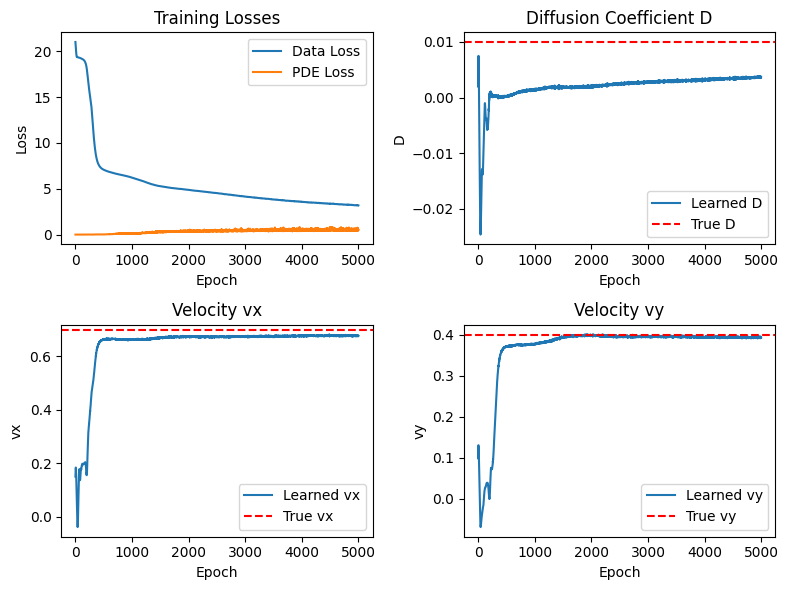

In [8]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
# for first subplot
plt.plot(loss_data_list, label='Data Loss')
plt.plot(loss_pde_list, label='PDE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

# Second subplot for D
plt.subplot(2, 2, 2)
plt.plot(D_list, label='Learned D')
plt.axhline(y=D, color='r', linestyle='--', label='True D')
plt.xlabel('Epoch')
plt.ylabel('D')
plt.title('Diffusion Coefficient D')
plt.legend()

# Third subplot for vx (u)
plt.subplot(2, 2, 3)
plt.plot(vx_list, label='Learned vx')
plt.axhline(y=v, color='r', linestyle='--', label='True vx')
plt.xlabel('Epoch')
plt.ylabel('vx')
plt.title('Velocity vx')
plt.legend()

# Fourth subplot for vy (v)
plt.subplot(2, 2, 4)
plt.plot(vy_list, label='Learned vy')
plt.axhline(y=u, color='r', linestyle='--', label='True vy')
plt.xlabel('Epoch')
plt.ylabel('vy')
plt.title('Velocity vy')
plt.legend()

plt.tight_layout()
plt.show()


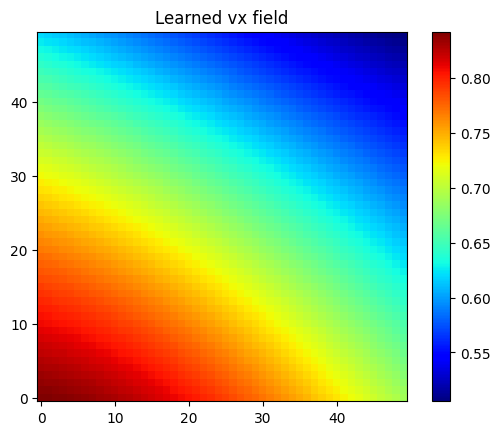

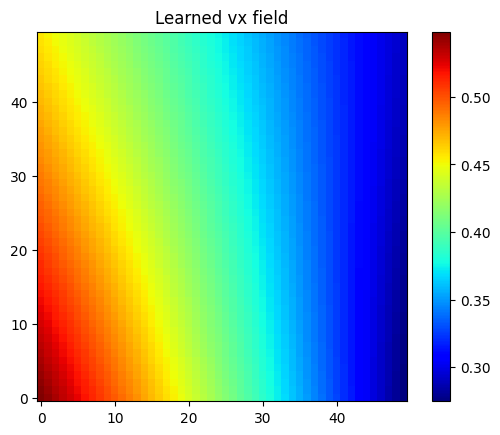

In [ ]:
# After training
x_grid = torch.linspace(0, Lx, nx, device=device).unsqueeze(1).repeat(1, ny).flatten().unsqueeze(1)
y_grid = torch.linspace(0, Ly, ny, device=device).repeat(nx).unsqueeze(1)
vx_field = pinn.vx_net(torch.cat([x_grid, y_grid], dim=1)).detach().cpu().numpy().reshape(nx, ny)
plt.imshow(vx_field.T, cmap='jet', origin='lower')
plt.colorbar()
plt.title('Learned vx field')
plt.show()


x_grid = torch.linspace(0, Lx, nx, device=device).unsqueeze(1).repeat(1, ny).flatten().unsqueeze(1)
y_grid = torch.linspace(0, Ly, ny, device=device).repeat(nx).unsqueeze(1)
vy_field = pinn.vy_net(torch.cat([x_grid, y_grid], dim=1)).detach().cpu().numpy().reshape(nx, ny)
plt.imshow(vy_field.T, cmap='jet', origin='lower')
plt.colorbar()
plt.title('Learned vy field')
plt.show()


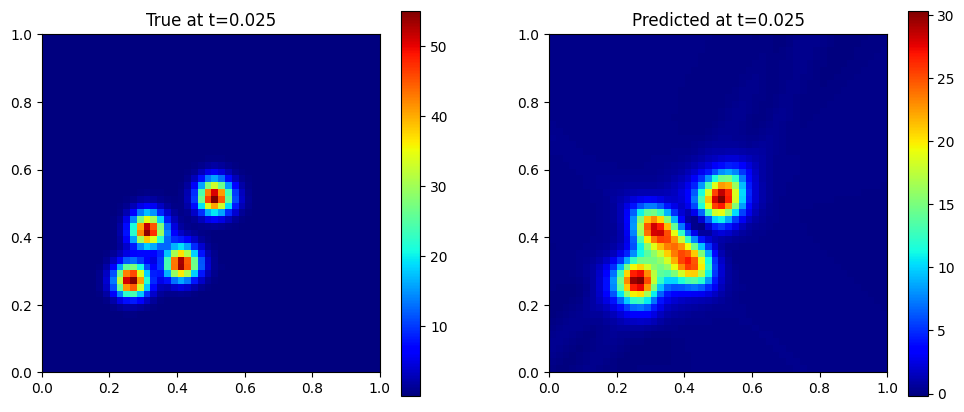

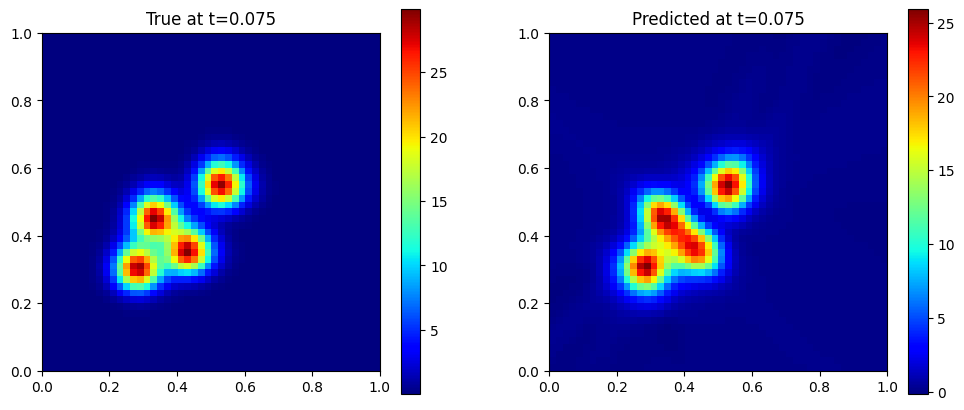

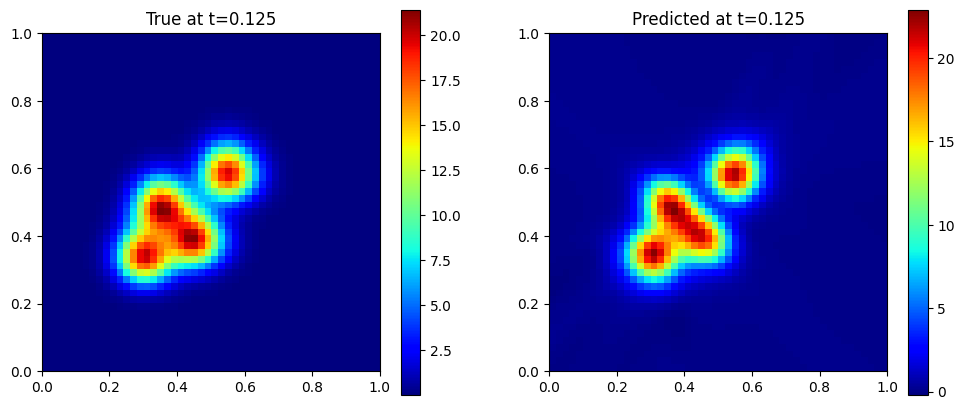

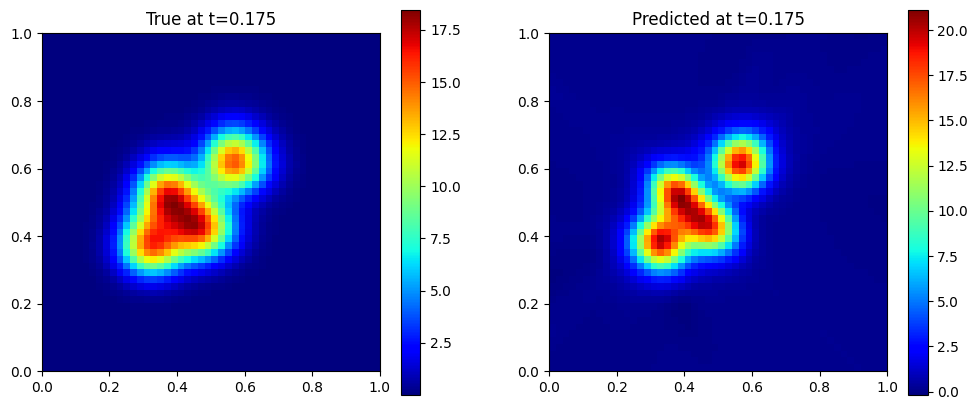

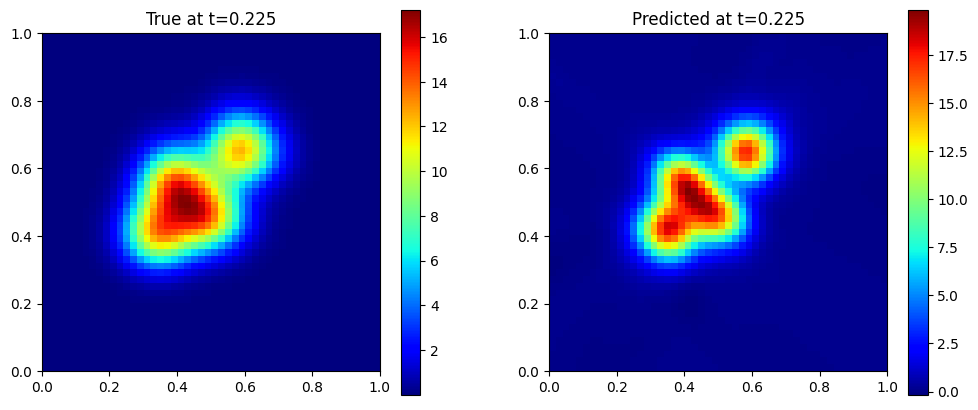

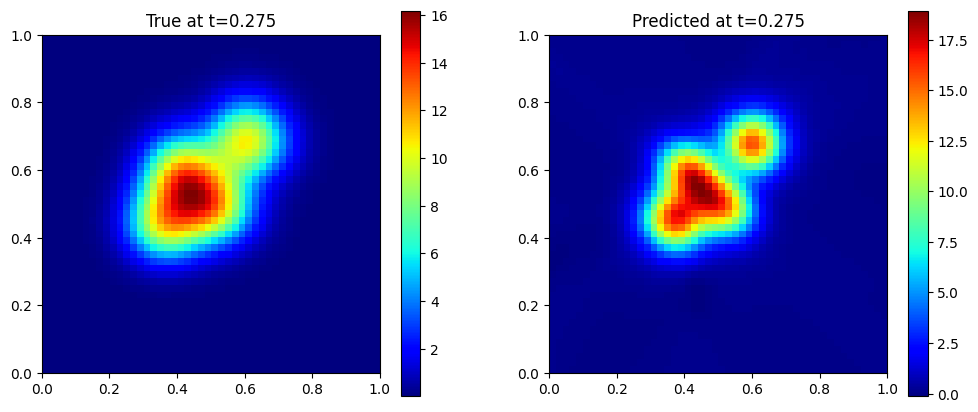

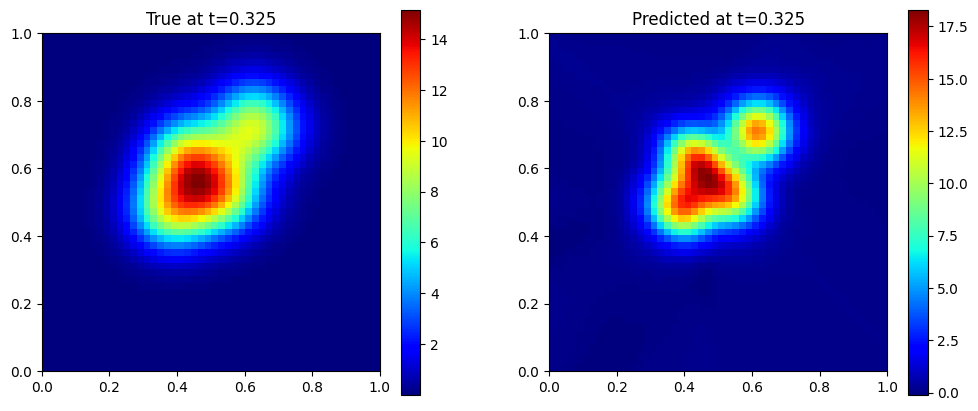

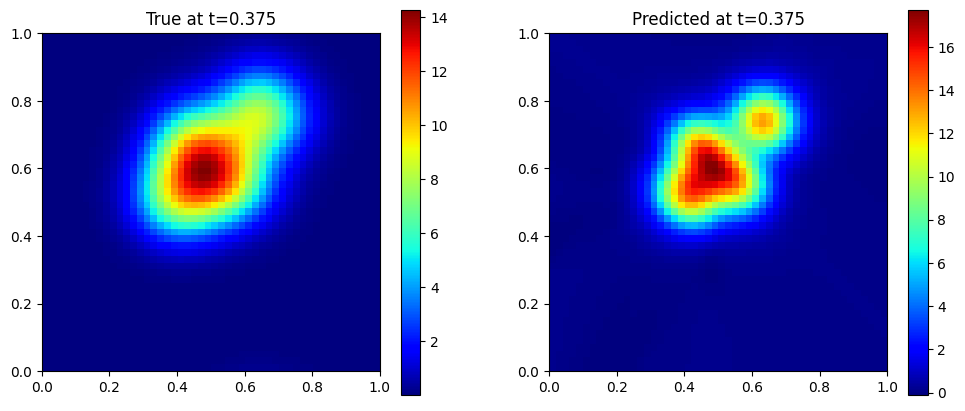

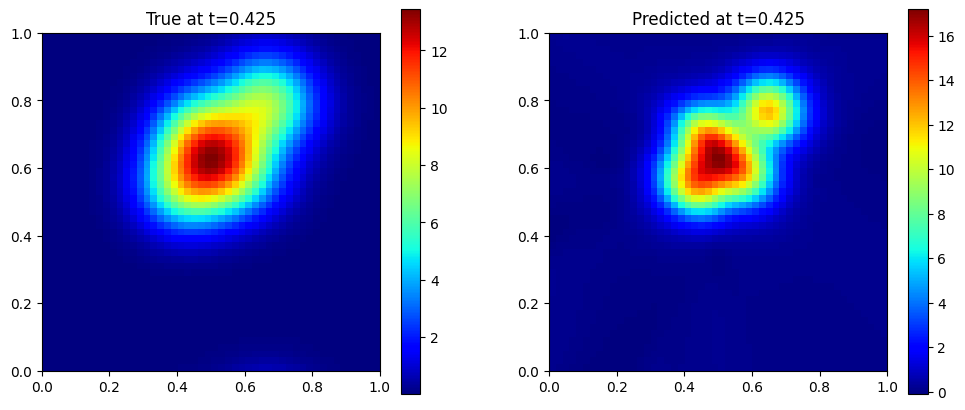

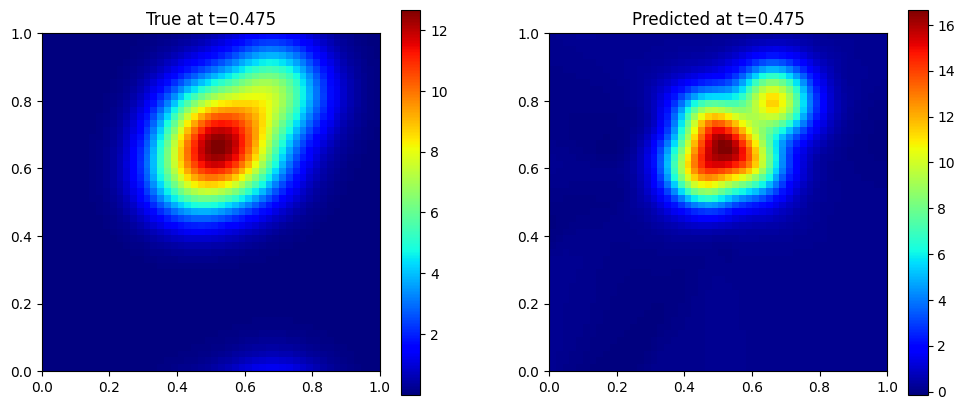

In [10]:
# draw predictions heatmap on test data
pinn.eval()
with torch.no_grad():
    n_test = test_rho_array.shape[-1]
    t_test = dt * (np.arange(n_test) * jump_t + jump_t/2) # align with test_rho_array time steps
    for i in range(n_test):
        x_in = np.linspace(0, Lx, nx)
        y_in = np.linspace(0, Ly, ny)

        t_in = np.array([t_test[i]]) # t_in is a fixed time step
        
        X_in, Y_in, T_in = np.meshgrid(x_in, y_in, t_in)
        X_test = np.stack([X_in.ravel(), Y_in.ravel(), T_in.ravel()], axis=1).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_test).to(device)
        # print(x_in.shape, y_in.shape, t_in.shape)

        y_pred = pinn(X_test_tensor[:,0:1], X_test_tensor[:,1:2], X_test_tensor[:,2:3])
        
        y_pred_np = y_pred.cpu().numpy().reshape(nx, ny)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1) # get the ith time step
        plt.imshow(test_rho_array[:,:,i].T, cmap='jet', origin='lower', extent=(0, Lx, 0, Ly))
        plt.colorbar()
        plt.title(f"True at t={t_test[i]:.3f}")
        
        plt.subplot(1, 2, 2)
        plt.imshow(y_pred_np.T, cmap='jet', origin='lower', extent=(0, Lx, 0, Ly))
        plt.colorbar()
        plt.title(f"Predicted at t={t_test[i]:.3f}")
        
        plt.show()